In [5]:
# -*- coding: utf-8 -*-

# Adresse des deux fichiers de donnees
# https://perso.univ-rennes1.fr/valerie.monbet/MachineLearning/TCGA-PANCAN-HiSeq-801x20531/data.csv
# https://perso.univ-rennes1.fr/valerie.monbet/MachineLearning/TCGA-PANCAN-HiSeq-801x20531/labels.csv

import numpy as np

print("N'oubliez pas de mettre votre numero d'etudiant") 
etudiant = 26109551 # nombre à  remplacer par votre numéro d'etudiant
np.random.seed(etudiant)

# On lit la premiere ligne pour obtenir le nombre de colonnes
X = np.loadtxt("data.csv",max_rows=1,delimiter=",",dtype=str)
nvars=len(X)-1

# Lecture des donnees correpondant aux nvars premieres variables
# et a la moitie des individus.
print("Vous pouvez choisir le nombre de variables nvars.")
nvars=200
print("Sont lues les donnees correpondant aux nvars=",nvars,
      "premieres variables et a moitie des individus",
      "(tiree aleatoirement sur la base de votre numero d'etudiant)")
X = np.loadtxt("data.csv",skiprows=1,delimiter=",",usecols=np.arange(nvars)+1)
nech=X.shape[0]//2
y =np.loadtxt("labels.csv",delimiter=",",skiprows=1,dtype=str)
per=np.random.permutation(X.shape[0])[:nech]
X,y = X[per,:], y[per,1]

print("Nombre de lignes, nombre de colonnes : ",X.shape)

# Elimination des variables constantes
l=np.std(X,axis=0)>1.e-8
X=X[:,l]
print("Nombre de lignes et colonnes, apres elimination des variables constantes: ",X.shape)




N'oubliez pas de mettre votre numero d'etudiant
Vous pouvez choisir le nombre de variables nvars.
Sont lues les donnees correpondant aux nvars= 200 premieres variables et a moitie des individus (tiree aleatoirement sur la base de votre numero d'etudiant)
Nombre de lignes, nombre de colonnes :  (150, 200)
Nombre de lignes et colonnes, apres elimination des variables constantes:  (150, 197)


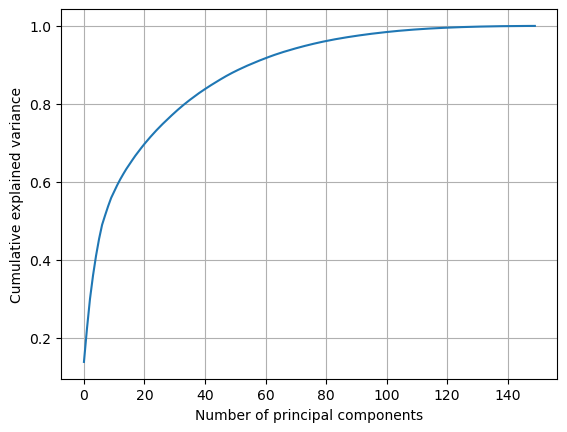

Number of components for 90% explained variance: 56
Premières classes:     [3 2 2 4 3 2 3 2 2 0 0 4 1 0 4 4 0 2 4 0]
Premières étiquettes:  ['BRCA' 'PRAD' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'LUAD'
 'KIRC' 'KIRC' 'PRAD' 'LUAD' 'LUAD' 'LUAD' 'LUAD' 'KIRC' 'PRAD' 'BRCA']

Classe................ 0 1 2 3 4
Etiquette majoritaire.. KIRC LUAD BRCA BRCA BRCA
Taux de mal classés: 0.627


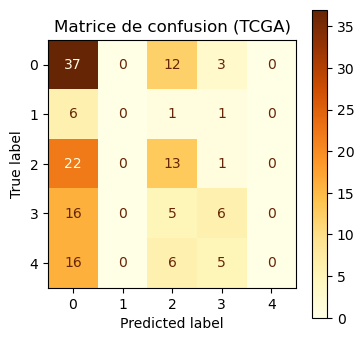

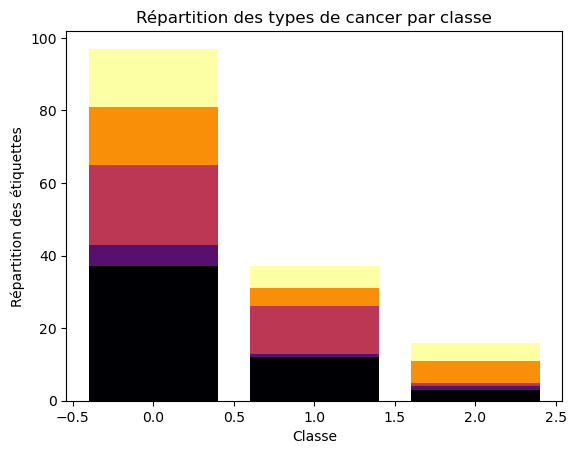

Matrice associée (conf_mat[etiq, classe]):

[[37 12  3]
 [ 6  1  1]
 [22 13  1]
 [16  5  6]
 [16  6  5]]
   Une ligne = un type de cancer
   Une colonne = une classe


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ============================================================================
# Make sure labels are of a single type
# ============================================================================

y = y.astype(str)

# ============================================================================
# Standardization
# ============================================================================

Std = StandardScaler()
Xs = Std.fit_transform(X)

# ============================================================================
# PCA
# ============================================================================

pca = PCA()
Z = pca.fit_transform(Xs)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.grid()
plt.show()

# Number of components explaining at least 90% of the variance
q = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.9) + 1
print("Number of components for 90% explained variance:", q)

# ============================================================================
# Clustering with KMeans (on PCA-reduced data)
# ============================================================================

nclus = len(np.unique(y))

k_means = KMeans(
    init='k-means++',
    n_clusters=nclus,
    n_init=10,
    random_state=0
)

k_means.fit(Z[:, :q])
cl = k_means.labels_

print('Premières classes:    ', cl[:20])
print('Premières étiquettes: ', y[:20])

# ============================================================================
# Majority label per cluster + error rate
# ============================================================================

maj_lab = np.zeros(nclus, dtype=object)

for k in range(nclus):
    counts = np.unique(y[cl == k], return_counts=True)
    maj_lab[k] = counts[0][np.argmax(counts[1])]

print("\nClasse".ljust(23,'.'), *range(nclus))
print("Etiquette majoritaire".ljust(23,'.'), *maj_lab)

err = np.mean(y != maj_lab[cl])
print("Taux de mal classés:", err.round(3))

# ============================================================================
# Confusion matrix (majority-label based)
# ============================================================================

conf_mat = confusion_matrix(y, maj_lab[cl])

plt.rcParams.update({'figure.figsize': (4,4), 'font.size': 10})
ConfusionMatrixDisplay(conf_mat).plot(cmap='YlOrBr')
plt.title("Matrice de confusion (TCGA)")
plt.show()
plt.rcdefaults()

# ============================================================================
# Barplot representation of label distribution per cluster
# ============================================================================

def BarPlotMat(M):
    I, J = M.shape
    ind = np.arange(J)
    haut = np.zeros(J)
    for i in range(I):
        plt.bar(
            ind,
            M[i, :],
            bottom=haut,
            color=plt.cm.inferno(i / max(I-1, 1))
        )
        haut += M[i, :]

conf_mat2 = confusion_matrix(y, maj_lab[cl])
conf_mat2 = conf_mat2[np.sum(conf_mat2, axis=1) > 0, :]
conf_mat2 = conf_mat2[:, np.sum(conf_mat2, axis=0) > 0]

plt.figure()
BarPlotMat(conf_mat2)
plt.xlabel("Classe")
plt.ylabel("Répartition des étiquettes")
plt.title("Répartition des types de cancer par classe")
plt.show()

print("Matrice associée (conf_mat[etiq, classe]):\n")
print(conf_mat2)
print("   Une ligne = un type de cancer")
print("   Une colonne = une classe")


Number of PCA components used: 56
k =  1 | misclassification rate = 0.653
k =  2 | misclassification rate = 0.653
k =  3 | misclassification rate = 0.653
k =  4 | misclassification rate = 0.647
k =  5 | misclassification rate = 0.627
k = 10 | misclassification rate = 0.587
k = 20 | misclassification rate = 0.547
k = 30 | misclassification rate = 0.520
k = 40 | misclassification rate = 0.513
k = 50 | misclassification rate = 0.433
k = 60 | misclassification rate = 0.400
k = 70 | misclassification rate = 0.347
k = 80 | misclassification rate = 0.313
k = 90 | misclassification rate = 0.247
k = 100 | misclassification rate = 0.207
k = 110 | misclassification rate = 0.173
k = 120 | misclassification rate = 0.113
k = 130 | misclassification rate = 0.073
k = 140 | misclassification rate = 0.033
k = 150 | misclassification rate = 0.000


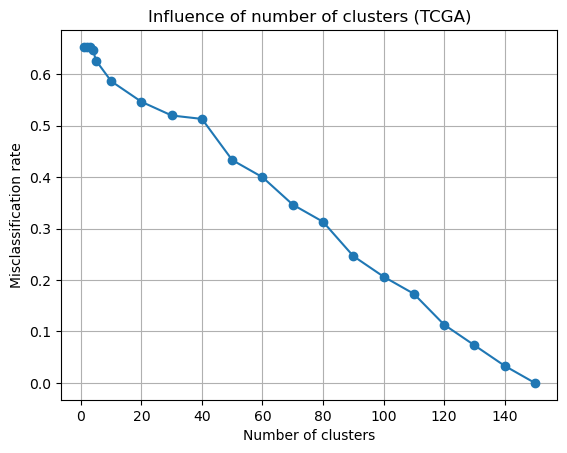

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ============================================================================
# Ensure labels are consistent
# ============================================================================

y = y.astype(str)

# ============================================================================
# Standardization + PCA (same as before)
# ============================================================================

Std = StandardScaler()
Xs = Std.fit_transform(X)

pca = PCA()
Z = pca.fit_transform(Xs)

# Number of components explaining at least 90% variance
q = np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.9) + 1
print("Number of PCA components used:", q)

# ============================================================================
# Study influence of number of clusters
# ============================================================================

Ks = [ 1,2,3,4,5, 10, 20, 30, 40, 50, 60,70,80,90,100,110, 120,130, 140,150]
errs = []

for k in Ks:
    k_means = KMeans(n_clusters=k, n_init=10, random_state=0)
    k_means.fit(Z[:, :q])
    cl = k_means.labels_

    # Majority label per cluster
    maj_lab = np.zeros(k, dtype=object)
    for i in range(k):
        counts = np.unique(y[cl == i], return_counts=True)
        maj_lab[i] = counts[0][np.argmax(counts[1])]

    err = np.mean(y != maj_lab[cl])
    errs.append(err)

    print(f"k = {k:2d} | misclassification rate = {err:.3f}")

# ============================================================================
# Plot error vs number of clusters
# ============================================================================

plt.figure()
plt.plot(Ks, errs, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Misclassification rate")
plt.title("Influence of number of clusters (TCGA)")
plt.grid()
plt.show()


The misclassification rate decreases monotonically as the number of clusters increases. This behavior is expected since increasing the number of clusters increases model flexibility. In the extreme case where the number of clusters equals the number of observations, each observation forms its own cluster, leading to a zero misclassification rate. This corresponds to severe over-clustering and does not reflect meaningful structure in the data.

PCA components (no standardization): 36
PCA components (standardized): 56
k =  2 | no std = 0.653 | std = 0.653
k =  3 | no std = 0.653 | std = 0.653
k =  4 | no std = 0.640 | std = 0.647
k =  5 | no std = 0.627 | std = 0.627
k =  8 | no std = 0.593 | std = 0.593
k = 10 | no std = 0.593 | std = 0.587
k = 15 | no std = 0.567 | std = 0.560
k = 20 | no std = 0.547 | std = 0.547


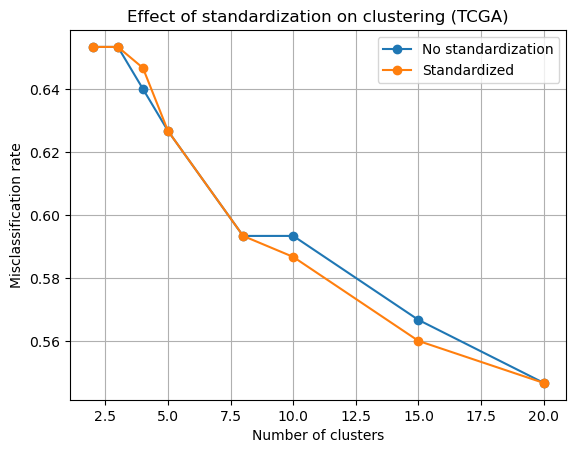

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ============================================================================
# Ensure labels are consistent
# ============================================================================

y = y.astype(str)

# ============================================================================
# PCA WITHOUT standardization
# ============================================================================

pca_ns = PCA()
Z_ns = pca_ns.fit_transform(X)

q_ns = np.searchsorted(np.cumsum(pca_ns.explained_variance_ratio_), 0.9) + 1
print("PCA components (no standardization):", q_ns)

# ============================================================================
# PCA WITH standardization
# ============================================================================

Std = StandardScaler()
Xs = Std.fit_transform(X)

pca_s = PCA()
Z_s = pca_s.fit_transform(Xs)

q_s = np.searchsorted(np.cumsum(pca_s.explained_variance_ratio_), 0.9) + 1
print("PCA components (standardized):", q_s)

# ============================================================================
# Study influence of standardization
# ============================================================================

Ks = [2, 3, 4, 5, 8, 10, 15, 20]
#Ks = [ 1,2,3,4,5, 10, 20, 30, 40, 50, 60,70,80,90,100,110, 120,130, 140,150]
errs_ns = []
errs_s = []

for k in Ks:
    # ----- No standardization -----
    k_means = KMeans(n_clusters=k, n_init=10, random_state=0)
    k_means.fit(Z_ns[:, :q_ns])
    cl = k_means.labels_

    maj_lab = np.zeros(k, dtype=object)
    for i in range(k):
        counts = np.unique(y[cl == i], return_counts=True)
        maj_lab[i] = counts[0][np.argmax(counts[1])]

    err = np.mean(y != maj_lab[cl])
    errs_ns.append(err)

    # ----- With standardization -----
    k_means = KMeans(n_clusters=k, n_init=10, random_state=0)
    k_means.fit(Z_s[:, :q_s])
    cl = k_means.labels_

    maj_lab = np.zeros(k, dtype=object)
    for i in range(k):
        counts = np.unique(y[cl == i], return_counts=True)
        maj_lab[i] = counts[0][np.argmax(counts[1])]

    err = np.mean(y != maj_lab[cl])
    errs_s.append(err)

    print(f"k = {k:2d} | no std = {errs_ns[-1]:.3f} | std = {errs_s[-1]:.3f}")

# ============================================================================
# Plot comparison
# ============================================================================

plt.figure()
plt.plot(Ks, errs_ns, marker='o', label='No standardization')
plt.plot(Ks, errs_s, marker='o', label='Standardized')
plt.xlabel("Number of clusters")
plt.ylabel("Misclassification rate")
plt.title("Effect of standardization on clustering (TCGA)")
plt.legend()
plt.grid()
plt.show()


Standardization does not significantly change the misclassification rate in this dataset. This suggests that the variance differences among genes are not large enough to dominate the Euclidean distance after PCA. However, for larger numbers of clusters (k=10 and k=15), standardization provides a slight improvement, indicating that equal weighting of variables helps when clusters become more detailed.

1 PCA components → misclassification rate = 0.627
2 PCA components → misclassification rate = 0.627
3 PCA components → misclassification rate = 0.627
4 PCA components → misclassification rate = 0.613
5 PCA components → misclassification rate = 0.627
6 PCA components → misclassification rate = 0.620
7 PCA components → misclassification rate = 0.627
8 PCA components → misclassification rate = 0.627
9 PCA components → misclassification rate = 0.627
10 PCA components → misclassification rate = 0.627


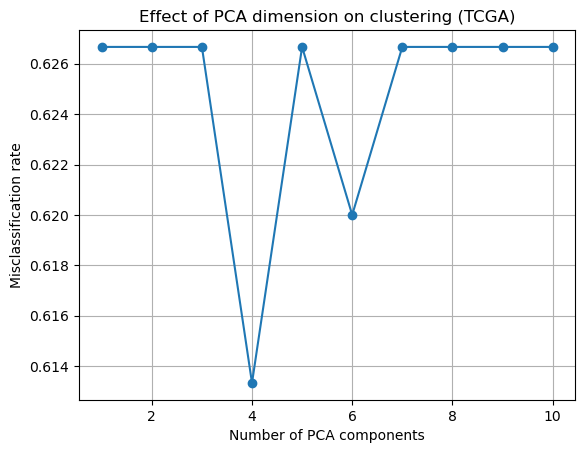

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Ensure labels are strings
y = y.astype(str)

# PCA matrix Z is already computed earlier:
# Z = pca.fit_transform(Xs)

# List of PCA dimensions to test
n_components_list = [1,2,3,4,5,6,7,8,9,10]
errs_pca = []

# Number of clusters = number of cancer types
nclus = len(np.unique(y))

for q in n_components_list:
    Zq = Z[:, :q]

    k_means = KMeans(n_clusters=nclus, n_init=10, random_state=0)
    k_means.fit(Zq)
    cl = k_means.labels_

    maj_lab = np.zeros(nclus, dtype=object)
    for i in range(nclus):
        counts = np.unique(y[cl == i], return_counts=True)
        maj_lab[i] = counts[0][np.argmax(counts[1])]

    err = np.mean(y != maj_lab[cl])
    errs_pca.append(err)
    print(f"{q} PCA components → misclassification rate = {err:.3f}")

plt.figure()
plt.plot(n_components_list, errs_pca, marker='o')
plt.xlabel("Number of PCA components")
plt.ylabel("Misclassification rate")
plt.title("Effect of PCA dimension on clustering (TCGA)")
plt.grid()
plt.show()


The misclassification rate remains almost constant for 1–10 PCA components. This happens because KMeans clustering assigns clusters in a way that the majority-label mapping does not change significantly. Supervised error alone is insufficient to evaluate cluster quality.

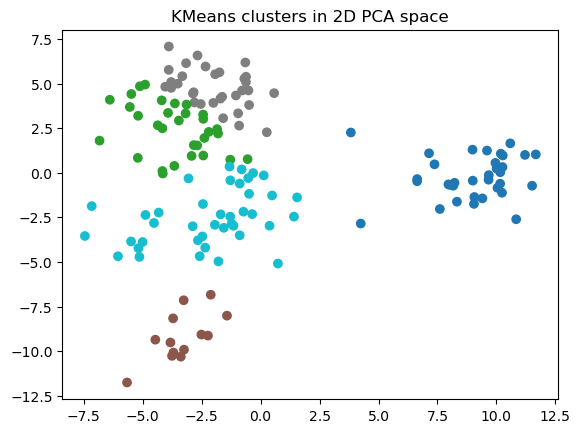

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Xs = StandardScaler().fit_transform(X)
Z2 = PCA(n_components=2).fit_transform(Xs)

cl = KMeans(n_clusters=5, random_state=0).fit(Z2).labels_

plt.scatter(Z2[:,0], Z2[:,1], c=cl, cmap='tab10')
plt.title("KMeans clusters in 2D PCA space")
plt.show()


Number of samples: 150
Number of variables: 197
Number of classes: 5

******* Classification Ascendante Hiérarchique (CAH) ******* 

----> !!! Choose the threshold (seuil) carefully !!!



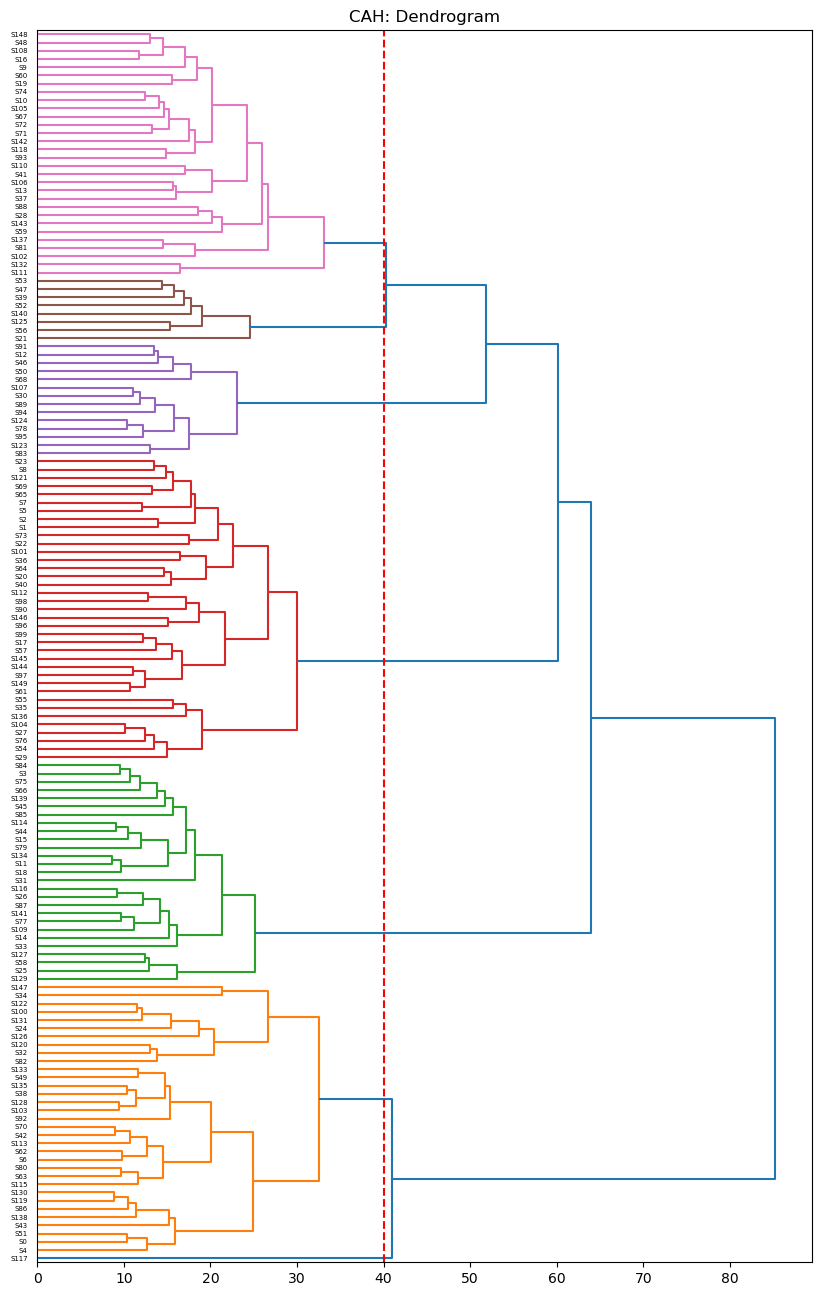


Number of clusters (CAH) at threshold = 7
Cluster 1   : 33
Cluster 2   : 1
Cluster 3   : 27
Cluster 4   : 37
Cluster 5   : 14
Cluster 6   : 8
Cluster 7   : 30


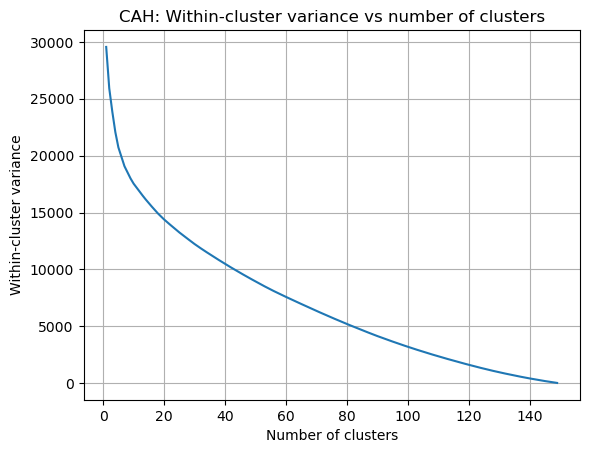


******* KMeans ******* 

Cluster 1   : 36
Cluster 2   : 27
Cluster 3   : 34
Cluster 4   : 16
Cluster 5   : 10
Cluster 6   : 24
Cluster 7   : 3

******* Inertia comparison ******* 

KMeans inertia with 7 clusters: 19326.38647736192
CAH inertia with 7 clusters: 19069.66034264827


In [36]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# -----------------------------------------
# Data
# -----------------------------------------

# X and y already exist from the first block
# y = y.astype(str)

# Standardize
Xs = StandardScaler().fit_transform(X)

# Use sample indices as "names"
sample_names = np.array([f"S{i}" for i in range(X.shape[0])])

print("Number of samples:", X.shape[0])
print("Number of variables:", X.shape[1])
print("Number of classes:", len(np.unique(y)))

# -----------------------------------------
# CAH (Hierarchical clustering)
# -----------------------------------------

print("\n******* Classification Ascendante Hiérarchique (CAH) ******* \n")

# Compute the dendrogram linkage
M = linkage(Xs, method='ward', metric='euclidean')

# Plot dendrogram
seuil = 40  # You may need to adjust this!
print("----> !!! Choose the threshold (seuil) carefully !!!\n")

plt.figure(figsize=(10, 16))
plt.title('CAH: Dendrogram')
d = dendrogram(M, labels=list(sample_names), orientation='right', color_threshold=seuil)
plt.axvline(x=seuil, color='r', linestyle='--')
plt.show()

# Extract groups
groupes = fcluster(M, t=seuil, criterion='distance')
nclus = np.max(groupes)

print("\nNumber of clusters (CAH) at threshold =", nclus)
for k in range(1, nclus + 1):
    print('Cluster', str(k).ljust(3, ' '), ':', np.sum(groupes == k))

# -----------------------------------------
# Variance intraclasse (within-cluster variance)
# -----------------------------------------

VI = np.cumsum(M[:, 2] ** 2) / 2

plt.figure()
plt.plot(np.arange(len(VI)) + 1, np.flip(VI, axis=0))
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster variance")
plt.title("CAH: Within-cluster variance vs number of clusters")
plt.grid()
plt.show()

# -----------------------------------------
# KMeans comparison
# -----------------------------------------

print("\n******* KMeans ******* \n")

k_means = KMeans(init='k-means++', n_clusters=nclus, n_init=10, random_state=0)
k_means.fit(Xs)

for k in range(nclus):
    print('Cluster', str(k+1).ljust(3, ' '), ':', np.sum(k_means.labels_ == k))

# -----------------------------------------
# Inertia comparison
# -----------------------------------------

print("\n******* Inertia comparison ******* \n")
print("KMeans inertia with", nclus, "clusters:", k_means.inertia_)
print("CAH inertia with", nclus, "clusters:", VI[-nclus])


Using a threshold of 40 in the dendrogram, CAH produces 7 clusters. KMeans with the same number of clusters produces a different partition. CAH inertia is slightly smaller than KMeans inertia, which is expected since Ward’s method directly optimizes within-cluster variance. The number of clusters does not match the number of true classes, indicating possible sub-structures in the data.


******* CAH with 5 clusters (automatic threshold) *******

Chosen threshold (seuil) for 5 clusters: 41.10275689223057
Number of clusters (CAH): 5
Cluster 1: 34 samples
Cluster 2: 27 samples
Cluster 3: 37 samples
Cluster 4: 14 samples
Cluster 5: 38 samples


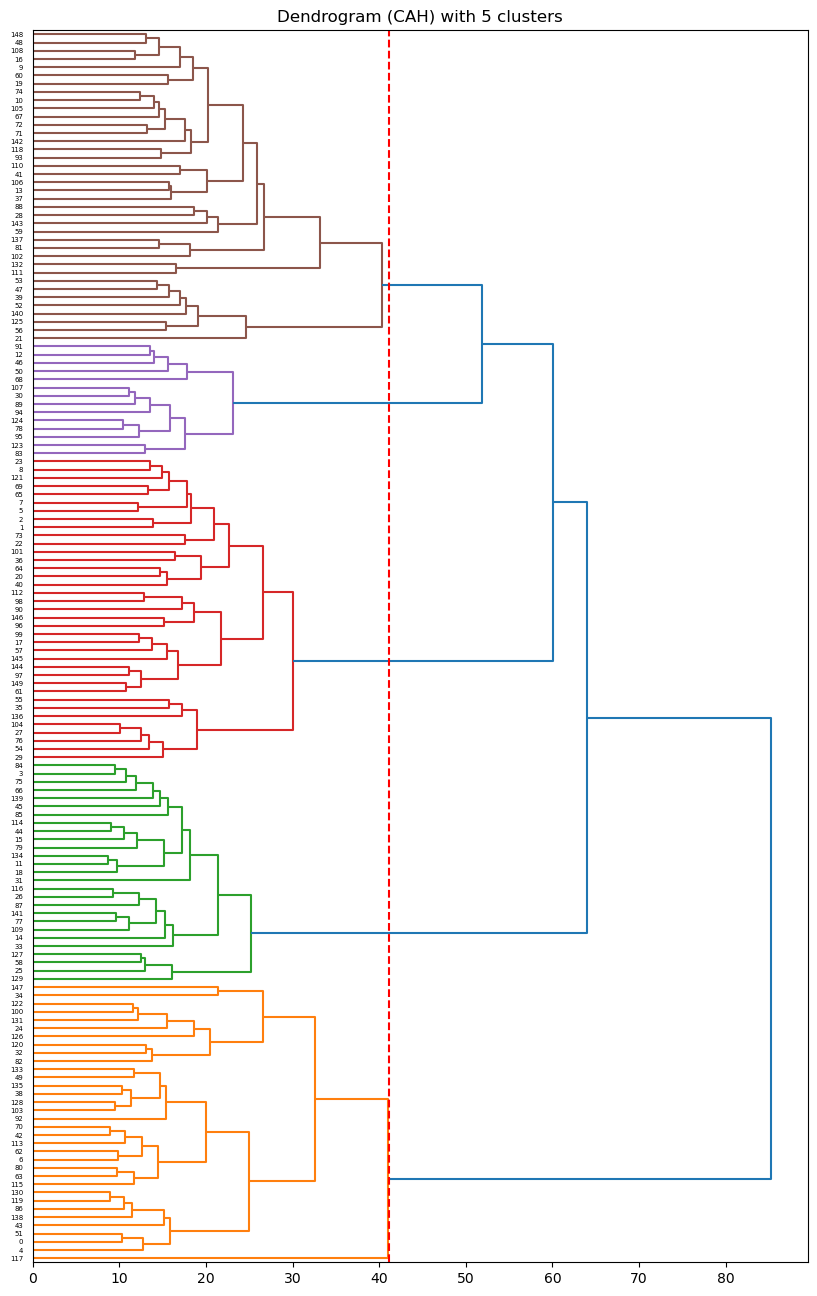


******* KMeans with 5 clusters *******

Cluster 1: 27 samples
Cluster 2: 37 samples
Cluster 3: 36 samples
Cluster 4: 34 samples
Cluster 5: 16 samples

Adjusted Rand Index (ARI):
CAH vs true labels: 0.005
KMeans vs true labels: 0.01

Inertia comparison:
KMeans inertia: 20687.48221320219
CAH inertia: 20724.115433515035


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

# Standardize
Xs = StandardScaler().fit_transform(X)

# -----------------------------------------
# CAH (Hierarchical clustering)
# -----------------------------------------
print("\n******* CAH with 5 clusters (automatic threshold) *******\n")

M = linkage(Xs, method='ward', metric='euclidean')

# Find threshold to get exactly 5 clusters
target_clusters = 5
seuil = None

for t in np.linspace(0, 200, 400):  # search range
    groupes = fcluster(M, t=t, criterion='distance')
    if np.max(groupes) == target_clusters:
        seuil = t
        break

print("Chosen threshold (seuil) for 5 clusters:", seuil)

groupes = fcluster(M, t=seuil, criterion='distance')
nclus = np.max(groupes)

print("Number of clusters (CAH):", nclus)
for k in range(1, nclus + 1):
    print(f"Cluster {k}: {np.sum(groupes == k)} samples")

# -----------------------------------------
# Plot dendrogram
# -----------------------------------------
plt.figure(figsize=(10, 16))
plt.title("Dendrogram (CAH) with 5 clusters")
dendrogram(M, labels=None, orientation='right', color_threshold=seuil)
plt.axvline(x=seuil, color='r', linestyle='--')
plt.show()

# -----------------------------------------
# KMeans with same number of clusters
# -----------------------------------------
print("\n******* KMeans with 5 clusters *******\n")

k_means = KMeans(n_clusters=target_clusters, n_init=10, random_state=0)
k_means.fit(Xs)

for k in range(target_clusters):
    print(f"Cluster {k+1}: {np.sum(k_means.labels_ == k)} samples")

# -----------------------------------------
# Compare to true labels using ARI
# -----------------------------------------
ari_cah = adjusted_rand_score(y, groupes)
ari_km = adjusted_rand_score(y, k_means.labels_)

print("\nAdjusted Rand Index (ARI):")
print("CAH vs true labels:", round(ari_cah, 3))
print("KMeans vs true labels:", round(ari_km, 3))

# -----------------------------------------
# Inertia comparison
# -----------------------------------------
VI = np.cumsum(M[:, 2] ** 2) / 2

print("\nInertia comparison:")
print("KMeans inertia:", k_means.inertia_)
print("CAH inertia:", VI[-target_clusters])


Setting the number of clusters to 5 makes the comparison between CAH and KMeans meaningful. Both methods produce similar cluster sizes, but ARI values remain very low, indicating that the clustering structure does not align with the true labels. KMeans shows slightly lower inertia, which is expected because it directly optimizes this criterion.

In [41]:
from sklearn.cluster import KMeans
import numpy as np

# Number of clusters (choose 5 to match true labels)
k = 5

# KMeans on standardized data
k_means = KMeans(n_clusters=k, n_init=20, random_state=0)
k_means.fit(Xs)

# Print cluster composition by true labels
for i in range(k):
    print(f"Cluster {i+1} ({np.sum(k_means.labels_ == i)} samples):")
    labels_in_cluster = y[k_means.labels_ == i]
    uniq, counts = np.unique(labels_in_cluster, return_counts=True)
    print(np.column_stack((uniq, counts)))
    print()


Cluster 1 (27 samples):
[['BRCA' '9']
 ['COAD' '1']
 ['KIRC' '6']
 ['LUAD' '6']
 ['PRAD' '5']]

Cluster 2 (37 samples):
[['BRCA' '12']
 ['COAD' '1']
 ['KIRC' '13']
 ['LUAD' '5']
 ['PRAD' '6']]

Cluster 3 (36 samples):
[['BRCA' '11']
 ['COAD' '2']
 ['KIRC' '11']
 ['LUAD' '6']
 ['PRAD' '6']]

Cluster 4 (34 samples):
[['BRCA' '17']
 ['COAD' '3']
 ['KIRC' '5']
 ['LUAD' '4']
 ['PRAD' '5']]

Cluster 5 (16 samples):
[['BRCA' '3']
 ['COAD' '1']
 ['KIRC' '1']
 ['LUAD' '6']
 ['PRAD' '5']]



In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np

# Standardize
Std = StandardScaler()
Xs = Std.fit_transform(X)

# CAH (Ward)
M_s = linkage(Xs, method='ward')

# Optional: names for samples (otherwise too many labels)
sample_names = np.array([f"S{i}" for i in range(X.shape[0])])

plt.figure(figsize=(10, 8))
dendrogram(M_s, labels=sample_names, orientation='right', color_threshold=None)
plt.title("CAH (standardized data)")
plt.show()

# Choose number of clusters
k = 5
groupes_s = fcluster(M_s, t=k, criterion='maxclust')

# Print cluster composition
for i in range(1, k+1):
    print(f"Cluster {i}: ", end='')
    print(np.sum(groupes_s == i), "samples")
